In [1]:
!pip install timm torch torchvision albumentations opencv-python pandas scikit-learn matplotlib seaborn tqdm pillow

In [2]:
from __future__ import print_function

import glob
import os
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
batch_size = 32
epochs = 10
lr = 5e-5
gamma = 0.7
seed = 42


def seed_everything(seed):
    """
    Sets the random seed for reproducibility in python, numpy, and torch.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device used :", device)

Device used : cuda


In [4]:
DATA_DIR = "/kaggle/input/ai-vs-human-generated-dataset"
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))

# Clean data
train_df = train_df.drop(columns=['Unnamed: 0'])  # Drop unnamed column
train_df['label'] = train_df['label'].astype(int)  # Ensure labels are integers

test_df = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
if 'Unnamed: 0' in test_df.columns:
    test_df = test_df.drop(columns=['Unnamed: 0'])
    
test_df['id'] = test_df['id'].apply(lambda x: os.path.join(DATA_DIR, x))
print(f"Train samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

Train samples: 79950
Test samples: 5540


In [5]:
import os

print("DATA_DIR:", DATA_DIR)
print("\nDATA_DIR contents:")
print(os.listdir(DATA_DIR))

print("\nTest DF first ID:")
print(test_df['id'].iloc[0])

DATA_DIR: /kaggle/input/ai-vs-human-generated-dataset

DATA_DIR contents:
['test_data_v2', 'train.csv', 'test.csv', 'train_data']

Test DF first ID:
/kaggle/input/ai-vs-human-generated-dataset/test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg


In [6]:
class ImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['file_name'])
        image = Image.open(img_path).convert('RGB')
        label = row['label']
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [7]:
class TestDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['id']  # This is already the full path
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Return the row index as the ID (0, 1, 2, 3...)
        return image, idx

In [8]:
# Check what the test data structure looks like
import os

print("Test DF columns:", test_df.columns.tolist())
print("First few IDs:", test_df['id'].head())
print("\nDirectory structure:")
print(os.listdir(DATA_DIR))

Test DF columns: ['id']
First few IDs: 0    /kaggle/input/ai-vs-human-generated-dataset/te...
1    /kaggle/input/ai-vs-human-generated-dataset/te...
2    /kaggle/input/ai-vs-human-generated-dataset/te...
3    /kaggle/input/ai-vs-human-generated-dataset/te...
4    /kaggle/input/ai-vs-human-generated-dataset/te...
Name: id, dtype: object

Directory structure:
['test_data_v2', 'train.csv', 'test.csv', 'train_data']


In [9]:
train_transform = transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),  # zoom_range
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [10]:
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'])

In [11]:
train_loader = DataLoader(
    ImageDataset(train_df, DATA_DIR, train_transform),
    batch_size=32,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    ImageDataset(val_df, DATA_DIR, val_transform),
    batch_size=32,
    shuffle=False,
    num_workers=2
)

# Use the test_data_v2 subdirectory
test_data_dir = os.path.join(DATA_DIR, 'test_data_v2')

# Recreate the test_loader with updated TestDataset
test_loader = DataLoader(
    TestDataset(test_df, DATA_DIR, test_transform),
    batch_size=batch_size,
    shuffle=False,  # IMPORTANT: Don't shuffle for test data!
    num_workers=2,
    pin_memory=True
)

In [12]:
# First, find out where the test images actually are
import os

# Check what's in DATA_DIR
print(f"\n2. Contents of DATA_DIR:")
try:
    contents = os.listdir(DATA_DIR)
    for item in contents:
        print(f"   - {item}")
except Exception as e:
    print(f"   Error: {e}")


possible_paths = [
    DATA_DIR,
    os.path.join(DATA_DIR, 'test_data_v2'),
    os.path.join(DATA_DIR, 'test'),
    '/kaggle/input/ai-vs-human-generated-dataset',
    '/kaggle/input/ai-vs-human-generated-dataset/test_data_v2'
]

for path in possible_paths:
    if os.path.exists(path):
        try:
            files = os.listdir(path)
            if any(f.endswith(('.jpg', '.png', '.jpeg')) for f in files[:10]):
                print(f"\n   ✓ Found images in: {path}")
                print(f"     First 3 files: {files[:3]}")
                
                # Try to construct the path for the first test image
                first_id = test_df['id'].iloc[0]
                test_path = os.path.join(path, first_id)
                print(f"     Testing path: {test_path}")
                print(f"     Exists: {os.path.exists(test_path)}")
                break
        except Exception as e:
            print(f"   ✗ Error checking {path}: {e}")


2. Contents of DATA_DIR:
   - test_data_v2
   - train.csv
   - test.csv
   - train_data

   ✓ Found images in: /kaggle/input/ai-vs-human-generated-dataset/test_data_v2
     First 3 files: ['37a05f4fddf84ac6bd2a9d49446c4c95.jpg', '3e74f0546c5d4b7797aca68370e6ccf0.jpg', '8e2aaa5b998a423e9c90df1c474a5351.jpg']
     Testing path: /kaggle/input/ai-vs-human-generated-dataset/test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
     Exists: True


In [13]:
from torchvision import models

model = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)
model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth


100%|██████████| 74.5M/74.5M [00:00<00:00, 176MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [14]:
# Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_f1s = []

In [15]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    epoch_accuracy = 0.0

    for data, label in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        data, label = data.to(device), label.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = output.argmax(dim=1)
        acc = (preds == label).float().mean().item()
        epoch_accuracy += acc

    epoch_loss /= len(train_loader)
    epoch_accuracy /= len(train_loader)

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # -- Validation --
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    val_pred_classes = []
    val_labels_list = []

    with torch.no_grad():
        for data, label in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            data, label = data.to(device), label.to(device)
            output = model(data)

            loss = criterion(output, label)
            val_loss += loss.item()

            preds = output.argmax(dim=1)
            acc = (preds == label).float().mean().item()
            val_acc += acc

            val_pred_classes.extend(preds.cpu().numpy())
            val_labels_list.extend(label.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    
    val_f1 = f1_score(val_labels_list, val_pred_classes)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1s.append(val_f1)

    print(
        f"Epoch [{epoch+1}/{epochs}] "
        f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_accuracy:.4f} | "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}"
    )

    scheduler.step()

Training Epoch 1:   0%|          | 0/1999 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/10] Train Loss: 0.2055 | Train Acc: 0.9147 | Val Loss: 0.0723 | Val Acc: 0.9731 | Val F1: 0.9734


Training Epoch 2:   0%|          | 0/1999 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/10] Train Loss: 0.0764 | Train Acc: 0.9706 | Val Loss: 0.0505 | Val Acc: 0.9804 | Val F1: 0.9805


Training Epoch 3:   0%|          | 0/1999 [00:00<?, ?it/s]

Validation Epoch 3:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/10] Train Loss: 0.0594 | Train Acc: 0.9776 | Val Loss: 0.0488 | Val Acc: 0.9819 | Val F1: 0.9821


Training Epoch 4:   0%|          | 0/1999 [00:00<?, ?it/s]

Validation Epoch 4:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/10] Train Loss: 0.0483 | Train Acc: 0.9816 | Val Loss: 0.0450 | Val Acc: 0.9829 | Val F1: 0.9831


Training Epoch 5:   0%|          | 0/1999 [00:00<?, ?it/s]

Validation Epoch 5:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/10] Train Loss: 0.0422 | Train Acc: 0.9835 | Val Loss: 0.0384 | Val Acc: 0.9856 | Val F1: 0.9857


Training Epoch 6:   0%|          | 0/1999 [00:00<?, ?it/s]

Validation Epoch 6:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/10] Train Loss: 0.0402 | Train Acc: 0.9845 | Val Loss: 0.0432 | Val Acc: 0.9828 | Val F1: 0.9829


Training Epoch 7:   0%|          | 0/1999 [00:00<?, ?it/s]

Validation Epoch 7:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/10] Train Loss: 0.0378 | Train Acc: 0.9856 | Val Loss: 0.0391 | Val Acc: 0.9852 | Val F1: 0.9854


Training Epoch 8:   0%|          | 0/1999 [00:00<?, ?it/s]

Validation Epoch 8:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/10] Train Loss: 0.0379 | Train Acc: 0.9860 | Val Loss: 0.0420 | Val Acc: 0.9841 | Val F1: 0.9842


Training Epoch 9:   0%|          | 0/1999 [00:00<?, ?it/s]

Validation Epoch 9:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/10] Train Loss: 0.0352 | Train Acc: 0.9870 | Val Loss: 0.0405 | Val Acc: 0.9846 | Val F1: 0.9847


Training Epoch 10:   0%|          | 0/1999 [00:00<?, ?it/s]

Validation Epoch 10:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/10] Train Loss: 0.0341 | Train Acc: 0.9874 | Val Loss: 0.0441 | Val Acc: 0.9836 | Val F1: 0.9837


In [16]:
torch.save(model.state_dict(), "model_weights.pth")

torch.save(model, "model.pth")

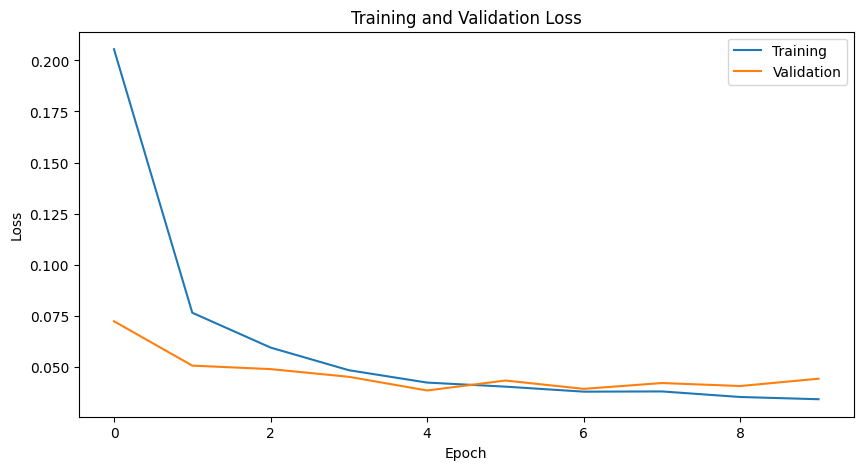

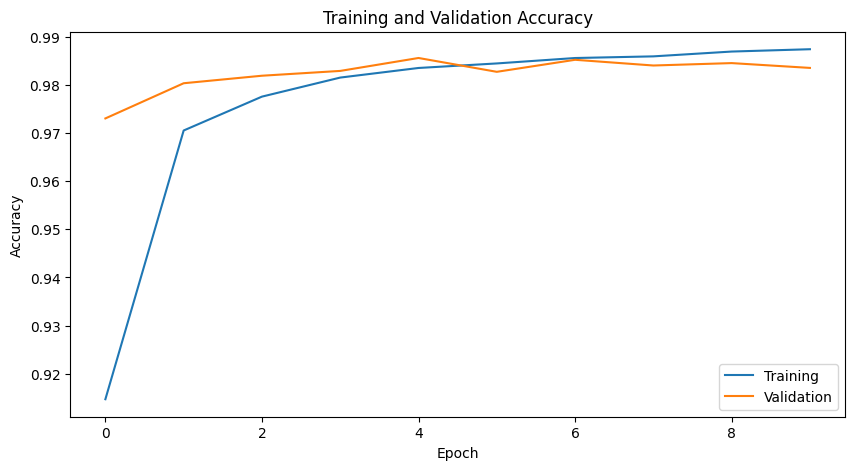

In [17]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(train_accuracies, label="Training")
plt.plot(val_accuracies, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [18]:
model.eval()
predictions = []
image_names = []

with torch.no_grad():
    for data, names in tqdm(test_loader, desc="Predicting"):
        data = data.to(device)
        outputs = model(data)
        
        # On récupère la classe prédite
        preds = outputs.argmax(dim=1)  # shape [batch_size]
        
        predictions.extend(preds.cpu().numpy())
        image_names.extend([f"test_data/{name}" for name in names])

# Créer le DataFrame au format "id,label"
submission_df = pd.DataFrame({
    'id': image_names,
    'label': predictions
})

Predicting:   0%|          | 0/174 [00:00<?, ?it/s]

In [19]:
submission_df.to_csv('/kaggle/working/submission.csv', index=False)

print("\n Submission file created at: /kaggle/working/submission.csv")


 Submission file created at: /kaggle/working/submission.csv
